In [1]:
import pandas as pd
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import glob

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

%matplotlib inline

## 파일 확인

In [2]:
data_path = '../../data/car_classification/'
train_csv = pd.read_csv(data_path + 'train.csv')
test_csv = pd.read_csv(data_path + 'test.csv')
class_csv = pd.read_csv(data_path + 'class.csv')
sample_submission_csv = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
train_csv

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44
...,...,...,...,...,...,...
10011,train_10012.jpg,61,206,996,621,122
10012,train_10013.jpg,127,45,665,412,176
10013,train_10014.jpg,23,13,231,112,151
10014,train_10015.jpg,24,103,561,387,59


In [4]:
test_csv

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93
...,...,...,...,...,...
6164,test_06165.jpg,8,141,618,344
6165,test_06166.jpg,39,123,846,436
6166,test_06167.jpg,44,96,621,360
6167,test_06168.jpg,71,29,767,305


In [24]:
class_csv

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
...,...,...
191,192,Volkswagen Beetle Hatchback 2012
192,193,Volvo C30 Hatchback 2012
193,194,Volvo 240 Sedan 1993
194,195,Volvo XC90 SUV 2007


In [5]:
sample_submission_csv

,img_file,class
0,test_00001.jpg,0
1,test_00002.jpg,0
2,test_00003.jpg,0
3,test_00004.jpg,0
4,test_00005.jpg,0
...,...,...
6164,test_06165.jpg,0
6165,test_06166.jpg,0
6166,test_06167.jpg,0
6167,test_06168.jpg,0


## EDA

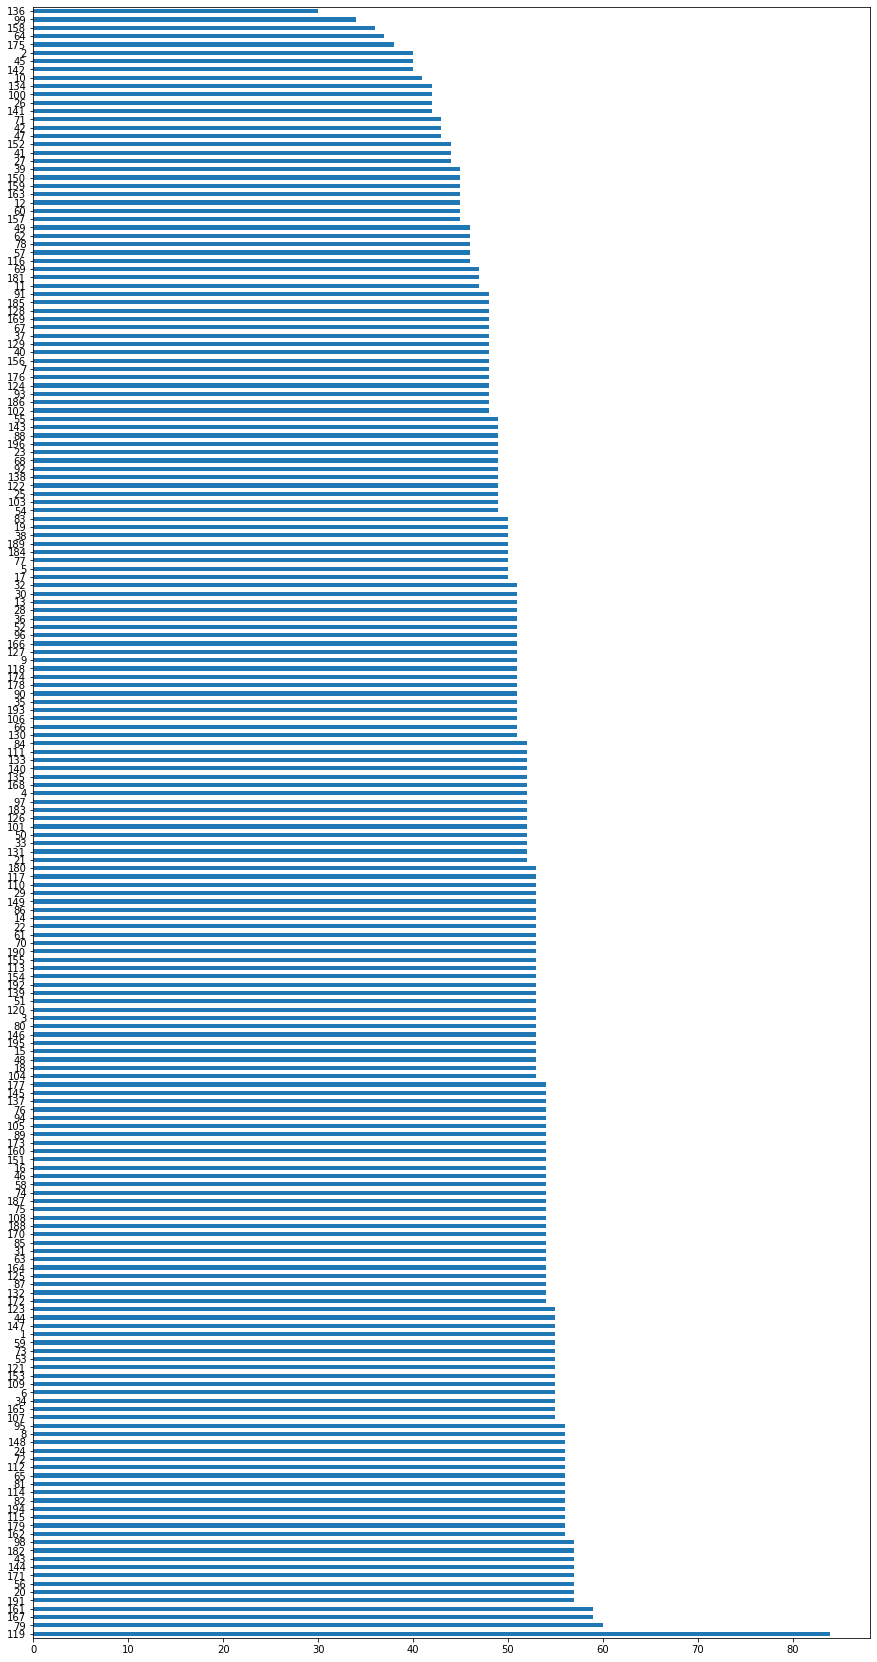

In [25]:
train_csv['class'].value_counts().plot(kind='barh', figsize=(15,30))

In [26]:
train_csv.columns

Index(['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class'], dtype='object')

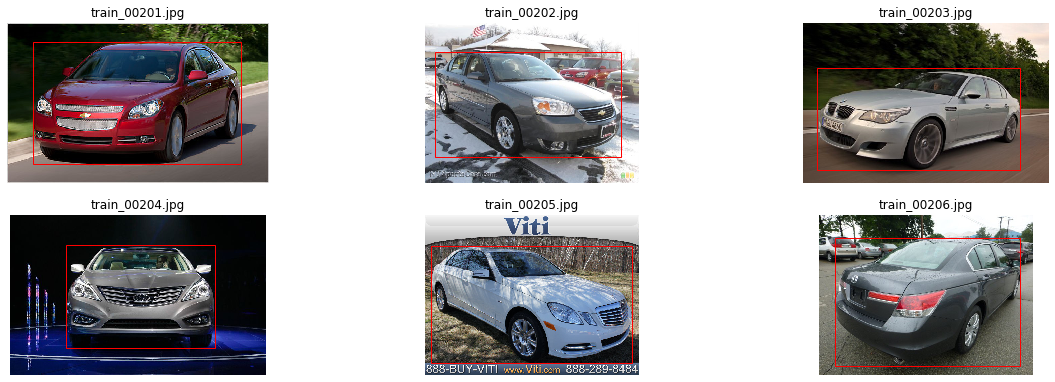

In [27]:
data_path = '../../data/car_classification/'


fig = plt.figure(figsize=(20,10))
for i, name in enumerate(train_csv['img_file'][200:206]):
    img = Image.open(data_path + 'train/' + name)
    pos = train_csv.loc[train_csv['img_file'] == name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].iloc[0].values
    
    ax = fig.add_subplot(3,3,i+1)
    x, y = pos[0], pos[1]
    w, h = pos[2] - pos[0], pos[3] - pos[1]
    rect = patches.Rectangle((x,y), w, h, linewidth = 1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

## dataloader

In [81]:
data_path = '../../data/car_classification/'

class mydataset(Dataset):
    def __init__(self, data_path, train=True, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        self.train_path = data_path + 'train/'
        self.test_path = data_path + 'test/'
        self.target_train = data_path + 'train.csv'
        self.target_test = data_path + 'test.csv'
        
        self.train = train
        if self.train:
            image_path = self.train_path
            target_path = self.target_train
        else:
            image_path = self.test_path
            target_path = self.target_test
            
        self.image_list = glob.glob(image_path + '*.jpg')
        self.target_list = pd.read_csv(target_path)
        
    def __len__(self):
        
        return len(self.image_list)
        
    def __getitem__(self, idx):
        img = self.image_list[idx]
        img = Image.open(img)
        target = self.target_list.iloc[idx, 5]
        
        if self.transform:
            img = self.transform(img)
        return img, target

In [99]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0,0,0), (1,1,1))
])

datasets = mydataset(data_path, train=True, transform=transform)
trainset, testset = torch.utils.data.random_split(datasets, [8000, 2016])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16)


print(iter(trainloader).next()[1])
print(iter(testloader).next()[1])

tensor([ 87,  55,  11,   9,  16,  34, 182,  65, 142,   1,  62,  31,   6, 183,
         17, 189,  45,  63,   6,  33, 122, 195, 170,  41, 147,  50,  40,  13,
        173, 160,  55,  47])
tensor([144,   3, 189, 139,  42,  55,  47,  27,  36, 160,  72, 157,  96, 122,
        107, 163])


In [100]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class mymodel(nn.Module):
    
    def __init__(self):
        super(mymodel, self).__init__()  
        self.conv1 = nn.Conv2d(3, 10, 5, padding = 2)
        self.conv2 = nn.Conv2d(10, 50, 5, padding = 2)
        self.conv3 = nn.Conv2d(50, 120, 5, padding = 2)
        self.conv4 = nn.Conv2d(120, 50, 5, padding = 2)
        self.conv5 = nn.Conv2d(50, 10, 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(10*8*8, 1200)
        self.fc2 = nn.Linear(1200, 500)
        self.fc3 = nn.Linear(500, 196)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 256 256 -> 128 128
        x = self.pool(F.relu(self.conv2(x))) # 128 128 -> 64 64
        x = self.pool(F.relu(self.conv3(x))) # 64 64 -> 32 32
        x = self.pool(F.relu(self.conv4(x))) # 32 32 -> 16 16
        x = self.pool(F.relu(self.conv5(x))) # 16 16 -> 8 8
        
        x = x.view(-1, 10*8*8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        out = self.fc3(x)
        return x

In [101]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mymodel()
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)

assert os.path.isdir('checkpoint'), 'checkpoint 없음!'
checkpoint = torch.load('./checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['model'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

AssertionError: checkpoint 없음!

In [102]:
EPOCH = 30

for epoch in range(EPOCH):

    model.train()
    train_loss = 0
    train_list = []
    total = 0
    for i, (images, targets) in enumerate(trainloader):
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += targets.size(0)
        
        if i % 50 == 0:
            print('(Train...) Epoch : [%d/%d] Iter : [%d/%d] Loss : %0.3f'
                     %(epoch+1, EPOCH, i, len(trainloader), train_loss/total))
    train_list.append(train_loss)              
    print('(Train...) Epoch : [%d/%d] Iter : [%d/%d] Loss : %0.3f----------------------------'
            %(epoch+1, EPOCH, i+1, len(trainloader), train_loss/total))                  
    
    model.eval()
    test_loss = 0
    test_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, targets) in enumerate(testloader):
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            loss = loss_func(outputs, targets)
            test_loss += loss.item()
            total = targets.size(0)
            
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            
            if i % 50 == 0:
                print('(Test...) Epoch : [%d/%d] Iter : [%d/%d] Loss : %0.3f Acc : %0.3f'
                         %(epoch+1, EPOCH, i, len(trainloader), test_loss/total, 100*correct/total))                
        test_list.append(test_loss)
        print('(Test...) Epoch : [%d/%d] Iter : [%d/%d] Loss : %0.3f Acc : %0.3f'
                %(epoch+1, EPOCH, i+1, len(trainloader), test_loss/total, 100*correct/total))
        
        
            
        

(Train...) Epoch : [1/30] Iter : [0/250] Loss : 0.194
(Train...) Epoch : [1/30] Iter : [50/250] Loss : 0.193
(Train...) Epoch : [1/30] Iter : [100/250] Loss : 0.192
(Train...) Epoch : [1/30] Iter : [150/250] Loss : 0.192
(Train...) Epoch : [1/30] Iter : [200/250] Loss : 0.191


KeyboardInterrupt: 